# Concept Activation Vectors (CAVs) example on CIFAR data
### Peter Xenopoulos

In this workbook, we will go over how to use CAVs on some popular image data -- the CIFAR datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import keras
from keras.datasets import cifar100, cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import sys
import os
sys.path.insert(0, os.path.abspath('../..'))

from cav.cav import *

np.random.seed(1996)

Using TensorFlow backend.


First we must import some images from CIFAR-10. We will import the _ships_ and the _dog_ images.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Keep airplanes (5) and ships (8) from CIFAR-10
ships = y_train == [8]
ship_indx = [i for i, x in enumerate(ships) if x]
x_train_class_one = x_train[ship_indx]
other = y_train == [2]
other_indx = [i for i, x in enumerate(other) if x]
x_train_class_two = x_train[other_indx]

x_train = np.append(x_train_class_one, x_train_class_two, axis = 0)
y_train = [1] * 5000
y_train = y_train + [0] * 5000

Below is an example of some of the images

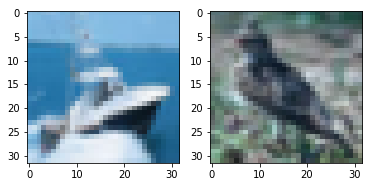

In [3]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[0])
axarr[1].imshow(x_train[7777])

Next, we must specify a _concept_. This is a certain idea we want to capture from our pictures. Let's say we are interested in the concept of the _sea_. Let's load in CIFAR-100 to get some pictures of the sea and some random counterexample, which we'll just make apples for ease of use.

In [4]:
(x_train_concept, y_train_concept), (x_test_concept, y_test_concept) = cifar100.load_data()

# keep sea (54) from CIFAR-100
concept = y_train_concept == [71]
indices = concept
indx_to_use = [i for i, x in enumerate(indices) if x]

x_train_concept = x_train_concept[indx_to_use]
y_train_concept = [1] * 500
y_train_concept = y_train_concept + [0] * 500

counterexamples = create_counterexamples(n = 500, height = 32, width = 32, channels = 3)
x_train_concept = np.append(x_train_concept, counterexamples, axis = 0)

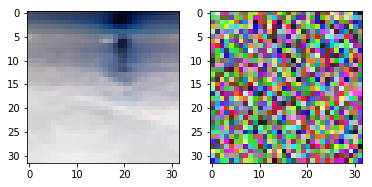

In [6]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train_concept[0])
axarr[1].imshow(x_train_concept[777])

Now, we must train our initial model. We do so below.

In [7]:
# Set parameters
batch_size = 32
epochs = 3

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# initiate optimizer
opt = keras.optimizers.Adam(lr=0.001)

# train the model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True)

Epoch 1/3
10000/10000 [==============================] - 30s 3ms/step - loss: 0.3531 - acc: 0.8390
Epoch 2/3
10000/10000 [==============================] - 29s 3ms/step - loss: 0.2277 - acc: 0.9073
Epoch 3/3
10000/10000 [==============================] - 29s 3ms/step - loss: 0.2000 - acc: 0.9217


In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

First, we split our model on a given layer. We can see that the last convolution layer is layer 8, but in order for our method to work, we need to include the activations and pooling and flattening. So, we will split on layer 12. Then, we train a binary classifier on our concepts. This will produce our concept activation vector.

In [9]:
model_f, model_h = return_split_models(model, 12)
cav_vec = train_cav(model_f, x_train_concept, y_train_concept)

Epoch 1/1
1000/1000 [==============================] - 0s 225us/step - loss: 0.2053 - acc: 0.9600


Below we see the concept activation vector

In [10]:
cav_vec

array([[-0.00449354],
       [ 0.0369009 ],
       [ 0.00166599],
       ...,
       [ 0.03432865],
       [ 0.03799578],
       [ 0.00332845]], dtype=float32)

Now, for each original training example, we calculate the sensitivity to the concept using our `cav_vec`

In [11]:
sensitivities = conceptual_sensitivity(x_train, model_f, model_h, cav_vec)

In [12]:
sensitivities[0:4999]

array([[-7.6736679e-04],
       [-5.0987466e-04],
       [-1.3415599e-02],
       ...,
       [-3.6195084e-02],
       [-7.2273135e-05],
       [-2.2597540e-02]], dtype=float32)

In [13]:
sensitivities[5000:]

array([[-0.0003502 ],
       [-0.11448987],
       [-0.00817972],
       ...,
       [-0.00130233],
       [-0.10007101],
       [-0.00027492]], dtype=float32)

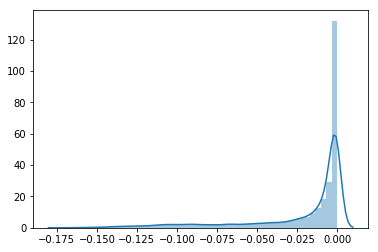

In [18]:
import seaborn as sns, numpy as np
sns.distplot(sensitivities)
plt.legend()

In [19]:
np.mean(sensitivities[0:4999])

-0.021019595

In [20]:
np.mean(sensitivities[5000:])

-0.023780948

# below is test

In [ ]:
# Set parameters
batch_size = 32
epochs = 3

In [ ]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Keep airplanes (0) and ships (8) from CIFAR-10
airplanes = y_train == [0]
ships = y_train == [8]
indices = airplanes + ships
indx_to_use = [i for i, x in enumerate(indices) if x]

x_train = x_train[indx_to_use]
y_train = y_train[indx_to_use]

y_train = (y_train == 8).astype(int)
y_train = np.concatenate(y_train).ravel().tolist()

# Ships are now 1, airplanes are 0

# keep cloud (50) and sea (54) from CIFAR-100
(x_train_concept, y_train_concept), (x_test_concept, y_test_concept) = cifar100.load_data()

other = y_train_concept == [47]
concept = y_train_concept == [54]
indices = other + concept
indx_to_use = [i for i, x in enumerate(indices) if x]

x_train_concept = x_train_concept[indx_to_use]
y_train_concept = y_train_concept[indx_to_use]
y_train_concept = (y_train_concept == 54).astype(int)
y_train_concept = np.concatenate(y_train_concept).ravel().tolist()
# Sea is now 1, clouds are 0

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# initiate optimizer
opt = keras.optimizers.Adam(lr=0.001)

# train the model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True)

In [ ]:
''' Utilities for concept activation vectors '''
import numpy as np

from keras import backend as k
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.optimizers import Adam

def return_split_models(model, layer):
    ''' Split a model into model_f and model_h

    Parameters
    ----------
    model : (keras.engine.sequential.Sequential)
        Keras sequential model to split
    layer : (int)
        Integer specifying layer to split model on

    Returns
    -------
    model_f : (keras.engine.sequential.Sequential)
        Keras sequential model that is the first part
    model_h : (keras.engine.sequential.Sequential)
        Keras sequential model that is the second part
    '''
    model_f, model_h = Sequential(), Sequential()
    for current_layer in range(0, layer+1):
        model_f.add(model.layers[current_layer])
    # Write input layer for model_h
    model_h.add(InputLayer(input_shape=model.layers[layer+1].input_shape[1:]))
    for current_layer in range(layer+1, len(model.layers)):
        model_h.add(model.layers[current_layer])
    return model_f, model_h

def train_cav(model_f, x_concept, y_concept):
    ''' Return the concept activation vector for the concept

    Parameters
    ----------
    model_f : (keras.engine.sequential.Sequential)
        First Keras sequential model from return_split_models()
    x_concept : (numpy.ndarray)
        Training data for concept set, has same size as model training data
    y_concept : (numpy.ndarray)
        Labels for concept set, has same size as model training labels

    Returns
    -------
    cav : (numpy.ndarray)
        Concept activation vector
    '''
    concept_activations = model_f.predict(x_concept)
    binary_classifier = Sequential()
    binary_classifier.add(Dense(1, input_shape=concept_activations.shape[1:], activation='sigmoid'))
    binary_classifier.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    binary_classifier.fit(concept_activations, y_concept, batch_size=32, epochs=20, shuffle=True)
    cav = binary_classifier.layers[0].get_weights()[0]
    return cav

def conceptual_sensitivity(example, model_f, model_h, concept_cav):
    ''' Return the conceptual conceptual sensitivity for a given example

    Parameters
    ----------
    example : (numpy.ndarray)
        Example to calculate the concept sensitivity (be sure to reshape)
    model_f : (keras.engine.sequential.Sequential)
        First Keras sequential model from return_split_models()
    model_h : (keras.engine.sequential.Sequential)
        Second Keras sequential model from return_split_models()
    concept_cav : (numpy.ndarray)
        Numpy array with the linear concept activation vector for a given concept

    Returns
    -------
    sensitivity : (float32)
        Sensitivity for inputted examples
    '''
    example = np.expand_dims(example, axis = 0)
    model_f_activations = model_f.predict(example)[0]
    model_f_activations.shape = (1, model_h.input_shape[1])
    gradients = k.gradients(model_h.output, model_h.input)
    gradient_func = k.function([model_h.input], gradients)
    calc_grad = gradient_func([model_f_activations])[0]
    sensitivity = np.dot(calc_grad, concept_cav)
    return sensitivity


In [ ]:
model_f, model_h = return_split_models(model, 12)
cav_vec = train_cav(model_f, x_train_concept, y_train_concept)

In [ ]:
model_f_activations = model_f.predict(x_train)

In [ ]:
gradients = k.gradients(model_h.output, model_h.input)
gradient_func = k.function([model_h.input], gradients)

In [ ]:
calc_grad = gradient_func([model_f_activations])

In [ ]:
calc_grad = gradient_func([model_f_activations])[0]

In [ ]:
x = np.dot(calc_grad, cav_vec)

In [ ]:
def tcav_score(x_train, y_train, model, layer, x_concept, y_concept):
    ''' Returns the TCAV score for the training data to a given concept

    Parameters
    ----------
    x_train : (numpy.ndarray)
        Training data where the i-th entry as x_train[i] is one example
    y_train : (numpy.ndarray)
        Training labels where the i-th entry as y_train[i] is one example
    model : (keras.engine.sequential.Sequential)
        Trained model to use
    layer : (int)
        Integer specifying layer to split model on
    x_concept : (numpy.ndarray)
        Training data for concept set, has same size as model training data
    y_concept : (numpy.ndarray)
        Labels for concept set, has same size as model training labels

    Returns
    -------
    tcav : (list)
        TCAV score for given concept and class
    '''
    model_f, model_h = return_split_models(model, layer)
    concept_cav = train_cav(model_f, x_concept, y_concept)
    unique_labels = np.unique(y_train)
    tcav = []
    for label in unique_labels:
        training_subset = x_train[np.array(y_train) == 1]
        set_size = training_subset.shape[0]
        count_of_sensitivity = 0
        for example in training_subset:
            sensitivity = conceptual_sensitivity(example, model_f, model_h, concept_cav)
            print(sensitivity)
            if sensitivity > 0:
                count_of_sensitivity = count_of_sensitivity + 1
        tcav.append(count_of_sensitivity/set_size)
    return tcav
    

In [ ]:
tcav_score(x_train, y_train, model, 12, x_train_concept, y_train_concept)

In [ ]:
def train_cav(model_f, x_concept, y_concept):
    ''' Return the concept activation vector for the concept

    Parameters
    ----------
    model_f : (keras.engine.sequential.Sequential)
        First Keras sequential model from return_split_models()
    x_concept : (numpy.ndarray)
        Training data for concept set, has same size as model training data
    y_concept : (numpy.ndarray)
        Labels for concept set, has same size as model training labels

    Returns
    -------
    cav : (numpy.ndarray)
        Concept activation vector
    '''
    concept_activations = model_f.predict(x_concept)
    binary_classifier = Sequential()
    binary_classifier.add(Dense(1, input_shape=concept_activations.shape[1:], activation='sigmoid'))
    binary_classifier.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    binary_classifier.fit(concept_activations, y_concept, batch_size=32, epochs=20, shuffle=True)
    cav = binary_classifier.layers[0].get_weights()[0]
    return cav

concept_cav = train_cav(model_f, x_train_concept, y_train_concept)

In [ ]:
def conceptual_sensitivity(example, model_f, model_h, concept_cav):
    ''' Return the conceptual conceptual sensitivity for a given example

    Parameters
    ----------
    example : (numpy.ndarray)
        Example to calculate the concept sensitivity (be sure to reshape)
    model_f : (keras.engine.sequential.Sequential)
        First Keras sequential model from return_split_models()
    model_h : (keras.engine.sequential.Sequential)
        Second Keras sequential model from return_split_models()
    concept_cav : (numpy.ndarray)
        Numpy array with the linear concept activation vector for a given concept

    Returns
    -------
    sensitivity : (float32)
        Sensitivity for inputted examples
    '''
    model_f_activations = model_f.predict(example)[0]
    gradients = k.gradients(model_h.output, model_h.input)
    gradient_func = k.function([model_h.input], gradients)
    calc_grad = gradient_func([model_f_activations])[0]
    sensitivity = np.dot(calc_grad, concept_cav)
    return sensitivity

conceptual_sensitivity(x_train[0], model_f, model_h, concept_cav)

In [ ]:
model_f.predict(x_train)

In [ ]:
x_train[0]

In [ ]:
model_f = Sequential()
model_f.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:], weights = model.layers[0].get_weights()))
model_f.add(Activation('relu'))
model_f.add(Conv2D(32, (3, 3), weights = model.layers[2].get_weights()))
model_f.add(Activation('relu'))
model_f.add(MaxPooling2D(pool_size=(2, 2)))
model_f.add(Dropout(0.25))

model_f.add(Conv2D(64, (3, 3), padding='same', weights = model.layers[6].get_weights()))
model_f.add(Activation('relu'))
model_f.add(Conv2D(64, (3, 3), weights = model.layers[8].get_weights()))
model_f.add(Activation('relu'))
model_f.add(MaxPooling2D(pool_size=(2, 2)))
model_f.add(Flatten())

acts = model_f.predict(x_train_concept)

model_h = Sequential()
model_h.add(Dense(512, input_shape=acts.shape[1:], weights = model.layers[13].get_weights()))
model_h.add(Activation('relu'))
model_h.add(Dropout(0.5))
model_h.add(Dense(1, weights = model.layers[16].get_weights()))
model_h.add(Activation('sigmoid'))

concept_cav = train_cav(model_f, x_train_concept, y_train_concept)

In [ ]:
training_subset = x_train[np.array(y_train) == 1]

gradients = k.gradients(model_h.output, model_h.input)
gradient_func = k.function([model_h.input], gradients)
pos_sens = 0
list_sens = []
for train_ex in training_subset:
    example = train_ex.reshape((1, 32, 32, 3))
    example_f = model_f.predict(example)[0].reshape((1,2304))
    calc_grad = gradient_func([example_f])[0]
    sensitivity = np.dot(calc_grad, concept_cav)
    list_sens.append(sensitivity)
    if sensitivity > 0:
        pos_sens = pos_sens + 1


In [ ]:
import seaborn as sns, numpy as np
ax = sns.distplot(list_sens)
plt.show()

In [ ]:
training_subset = x_train[np.array(y_train) == 0]
i = 777
example = training_subset[i].reshape((1, 32, 32, 3))
example_f = model_f.predict(example)[0].reshape((1,2304))
gradients = k.gradients(model_h.output, model_h.input)
gradient_func = k.function([model_h.input], gradients)
calc_grad = gradient_func([example_f])[0]
sensitivity = np.dot(calc_grad, concept_cav)
sensitivity